In [1]:
import glob
import os

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline as CubicSpline

In [2]:
def interpolate_peak(x, y):
    max_indx = np.argmax(y)
    if (max_indx == 0) or (max_indx == y.size):
        x_peak = x[max_indx]
        y_peak = np.max(y)
    else:
        x_cut = x[max_indx-1:max_indx+2]
        y_cut = y[max_indx-1:max_indx+2]
    
        # Do a cubic spline fit to the data
        cs = CubicSpline(x_cut, y_cut)
        cs_der = cs.derivative()
    
        # Calculate the derivative, zero crossing corresponds to maximum
        x_interpol = np.linspace(x_cut[0], x_cut[-1], 100)
        der = cs_der(x_interpol)

        der_index = np.argmin(np.abs(der))

        x_peak = x_interpol[der_index]
        y_peak = cs(x_peak)
    return x_peak, y_peak

In [3]:
basepath_heatflux = '/home/users/tabu/eunpa_lim_project/EP_FLUX_DATA/{}/heat_fluxes/EP_heat_flux_{}_day_historical_{}_{}_monmean.nc'
basepath_eddymomfluxdiv = '/home/users/tabu/eunpa_lim_project/EP_FLUX_DATA/{}/momentum_flux_div/EP_momentum_flux_divergence_{}_day_historical_{}_{}_monmean.nc'

pattern = basepath_heatflux.format('*','*','*','*')
files = glob.glob(pattern)

model_name_list = []
version_name_list = []
time_name_list = []

# Find all files that match the above pattern and save the model names, the versions and the grid it was gridded to
for file in files:
    filename = os.path.basename(file).split("/")[-1]
    split_filename = os.path.basename(filename).split("_")
    model_name, version_name, time_name = split_filename[3], split_filename[-3], split_filename[-2]
    model_name_list.append(model_name)
    version_name_list.append(version_name)
    time_name_list.append(time_name)

# Heatflux

In [4]:
comb_list = [model_name_list[i] + ' ' + version_name_list[i] for i in range(len(model_name_list))]
df_maxpos = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)
df_maxstr = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)

for file,name in zip(files, comb_list):
    ds = xr.load_dataset(file)['EPp'].sel(plev=10000, drop=True)
    ds_clim = ds.groupby('time.month').mean('time')/10000
    
    for month in ds_clim.month.values:
        ds_clim_slice = ds_clim.sel(month=month, drop=True)
        ds_clim_slice = ds_clim_slice.sel(lat=slice(-87,0))
        
        maxpos, maxstr = interpolate_peak(ds_clim_slice.lat.values, -ds_clim_slice.values)
        df_maxstr[name].loc[month] = -maxstr
        df_maxpos[name].loc[month] = maxpos

In [5]:
era5_heatflux_datapath = '/home/users/tabu/eunpa_lim_project/EP_FLUX_DATA/ERA5/EP_heat_flux_ERA5_1979_2018_monmean.nc'
era5 = xr.load_dataset(era5_heatflux_datapath)['EPp'].sel(level=100, drop=True)
era5_clim = era5.groupby('time.month').mean('time')

df_era5= pd.DataFrame(columns=['maxpos', 'maxstr'] ,index = np.arange(12)+1)

for month in era5_clim.month.values:
    era5_clim_slice = era5_clim.sel(month=month, drop=True)
    era5_clim_slice = era5_clim_slice.sel(latitude=slice(0, -87))
    
    maxpos, maxstr = interpolate_peak(-era5_clim_slice.latitude.values, -era5_clim_slice.values)
    df_era5['maxstr'].loc[month] = -maxstr
    df_era5['maxpos'].loc[month] = -maxpos

Text(0.5, 1.0, '100 hPa Maximum Eddy Heat Flux Location')

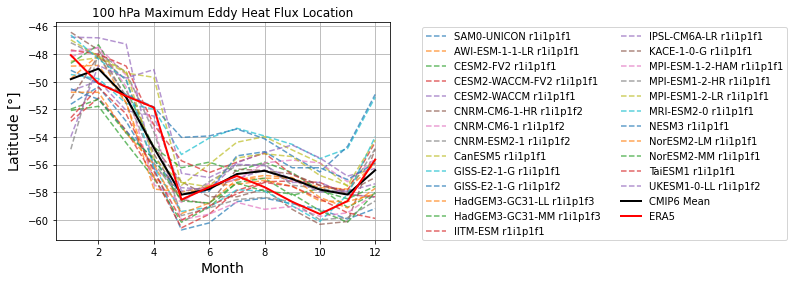

In [6]:
for name in comb_list:
    plt.plot(df_maxpos[name], '--', label=name, alpha = 0.7)

plt.plot(df_maxpos.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_era5['maxpos'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Latitude [$\degree$]', fontsize = 14)
plt.grid()
plt.title('100 hPa Maximum Eddy Heat Flux Location')
# plt.savefig('Plots/100hPa_Max_Heatflux_Pos.pdf', bbox_inches='tight')

Text(0.5, 1.0, '100 hPa Maximum Eddy Heat Flux Strength')

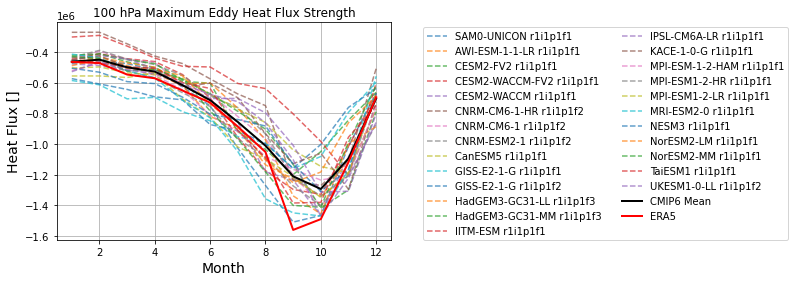

In [7]:
for name in comb_list:
    plt.plot(df_maxstr[name], '--', label=name, alpha = 0.7)

plt.plot(df_maxstr.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_era5['maxstr'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Heat Flux []', fontsize = 14)
plt.grid()
plt.title('100 hPa Maximum Eddy Heat Flux Strength')
# plt.savefig('Plots/100hPa_Max_Heatflux_Str.pdf', bbox_inches='tight')

# Eddy Momentum Flux Divergence

In [33]:
comb_list = [model_name_list[i] + ' ' + version_name_list[i] for i in range(len(model_name_list))]
df_emf_conv_maxpos = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)
df_emf_conv_maxstr = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)
df_emf_div_maxpos = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)
df_emf_div_maxstr = pd.DataFrame(columns=comb_list, index = np.arange(12)+1)

for name, version in zip(model_name_list, version_name_list):
    file = basepath_eddymomfluxdiv.format(name, name, version, '1979-2014')
    comb_name = name +' '+version
    try:
        ds = xr.load_dataset(file)['div_EPphi'].sel(plev=1000, drop=True)
        ds_clim = ds.groupby('time.month').mean('time')
        
        for month in ds_clim.month.values:
            ds_clim_slice = ds_clim.sel(month=month, drop=True)
            ds_clim_slice = ds_clim_slice.sel(lat=slice(-80,-20))
            
            maxpos, maxstr = interpolate_peak(ds_clim_slice.lat.values, ds_clim_slice.values)
            df_emf_conv_maxstr[comb_name].loc[month] = maxstr
            df_emf_conv_maxpos[comb_name].loc[month] = maxpos

            maxpos, maxstr = interpolate_peak(ds_clim_slice.lat.values, -ds_clim_slice.values)
            df_emf_div_maxstr[comb_name].loc[month] = -maxstr
            df_emf_div_maxpos[comb_name].loc[month] = maxpos
    except:
        df_emf_conv_maxpos.drop(comb_name, axis = 1)
        df_emf_conv_maxstr.drop(comb_name, axis = 1)
        print(name+' gave error')

GISS-E2-1-G gave error
GISS-E2-1-G gave error


In [34]:
era5_momfluxdiv_datapath = '/home/users/tabu/eunpa_lim_project/EP_FLUX_DATA/ERA5/EP_momentum_flux_divergence_ERA5_1979_2018_monmean.nc'
era5 = xr.load_dataset(era5_momfluxdiv_datapath)['div_EPphi'].sel(level=10, drop=True)
era5_clim = era5.groupby('time.month').mean('time')

df_emf_conv_era5= pd.DataFrame(columns=['maxpos', 'maxstr'] ,index = np.arange(12)+1)
df_emf_div_era5= pd.DataFrame(columns=['maxpos', 'maxstr'] ,index = np.arange(12)+1)

for month in era5_clim.month.values:
    era5_clim_slice = era5_clim.sel(month=month, drop=True)
    era5_clim_slice = era5_clim_slice.sel(latitude=slice(-20, -80))
    
    maxpos, maxstr = interpolate_peak(-era5_clim_slice.latitude.values, era5_clim_slice.values)
    df_emf_conv_era5['maxstr'].loc[month] = maxstr
    df_emf_conv_era5['maxpos'].loc[month] = -maxpos

    maxpos, maxstr = interpolate_peak(-era5_clim_slice.latitude.values, -era5_clim_slice.values)
    df_emf_div_era5['maxstr'].loc[month] = -maxstr
    df_emf_div_era5['maxpos'].loc[month] = -maxpos

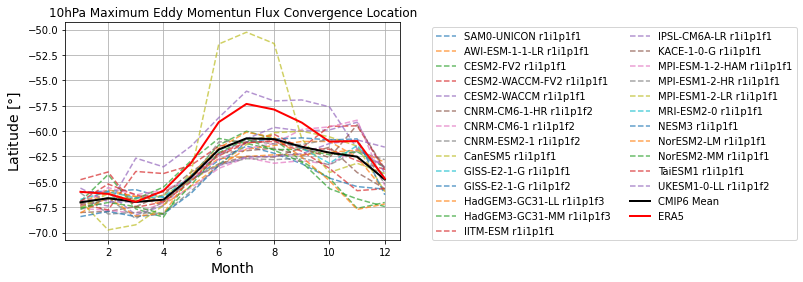

In [43]:
for name in df_emf_conv_maxpos.keys():
    plt.plot(df_emf_conv_maxpos[name], '--', label=name, alpha = 0.7)

plt.plot(df_emf_conv_maxpos.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_emf_conv_era5['maxpos'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Latitude [$\degree$]', fontsize = 14)
plt.grid()
plt.title('10hPa Maximum Eddy Momentun Flux Convergence Location')
plt.savefig('Plots/10hPa_Max_EddyMomfluxConv_Pos.pdf', bbox_inches='tight')

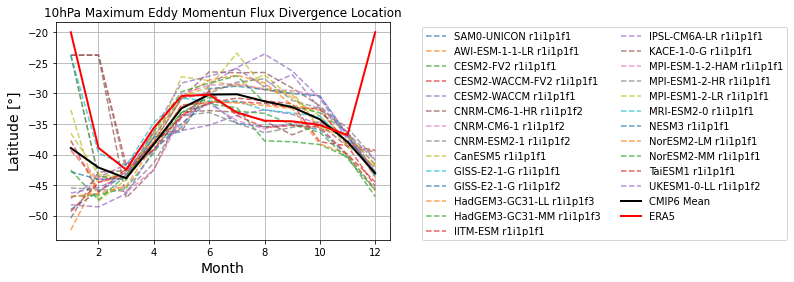

In [44]:
for name in df_emf_div_maxpos.keys():
    plt.plot(df_emf_div_maxpos[name], '--', label=name, alpha = 0.7)

plt.plot(df_emf_div_maxpos.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_emf_div_era5['maxpos'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Latitude [$\degree$]', fontsize = 14)
plt.grid()
plt.title('10hPa Maximum Eddy Momentun Flux Divergence Location')
plt.savefig('Plots/10hPa_Max_EddyMomfluxDiv_Pos.pdf', bbox_inches='tight')

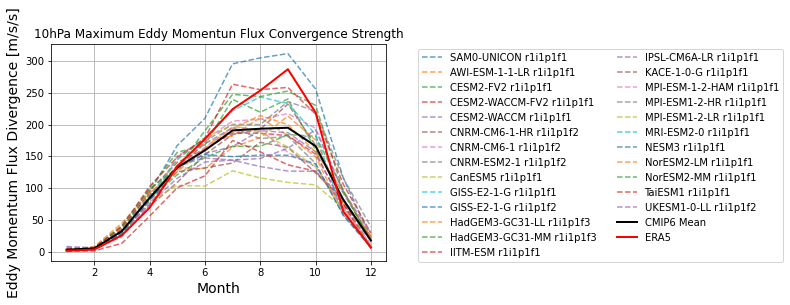

In [45]:
for name in df_emf_conv_maxstr.keys():
    plt.plot(df_emf_conv_maxstr[name], '--', label=name, alpha = 0.7)

plt.plot(df_emf_conv_maxstr.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_emf_conv_era5['maxstr'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Eddy Momentum Flux Divergence [m/s/s]', fontsize = 14)
plt.grid()
plt.title('10hPa Maximum Eddy Momentun Flux Convergence Strength')
plt.savefig('Plots/10hPa_Max_EddyMomfluxConv_Str.pdf', bbox_inches='tight')

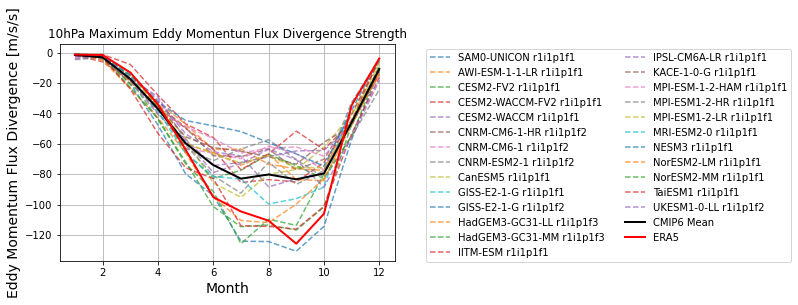

In [46]:
for name in df_emf_div_maxstr.keys():
    plt.plot(df_emf_div_maxstr[name], '--', label=name, alpha = 0.7)

plt.plot(df_emf_div_maxstr.mean(axis=1), color='black', label ='CMIP6 Mean', linewidth = 2)

plt.plot(df_emf_div_era5['maxstr'], color='red', label ='ERA5', linewidth = 2)

plt.legend(loc = 'upper right', ncol=2, bbox_to_anchor=(2.2, 1),)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Eddy Momentum Flux Divergence [m/s/s]', fontsize = 14)
plt.grid()
plt.title('10hPa Maximum Eddy Momentun Flux Divergence Strength')
plt.savefig('Plots/10hPa_Max_EddyMomfluxDiv_Str.pdf', bbox_inches='tight')